In [1]:
%matplotlib inline

### Install Python Packages

In [2]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

### Get MNIST Dataset and DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

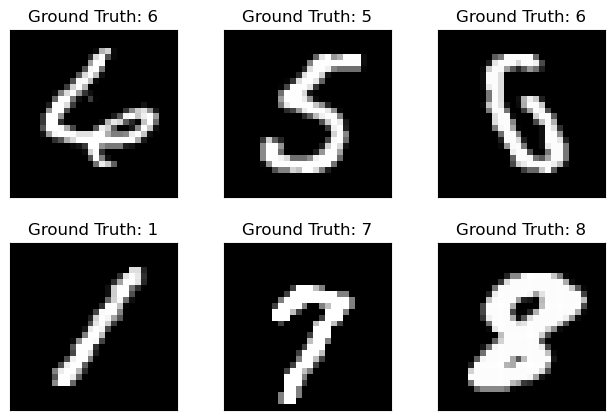

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Create MLP

In [5]:
class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out),
        )
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

### Create Convolutional Nerual Net

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Select Model and Define HyperParameters

In [7]:
model = CNN()

print(model)

epochs = 10
learning_rate = 0.001
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### Define Training Function

In [8]:
train_loss = []
train_count = []
test_loss = []
test_count = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, dataloader, optimizer):
    model.train()

    print(f'Train Epoch: {epoch}')

    for batch, (data, label) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        # loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if batch % status_interval == 0:
            # print(f'Train Epoch: {epoch} [{batch * len(data)}/{len(dataloader.dataset)}] ({batch * 100 / len(dataloader):.0f}%)\tLoss: {loss.item():.6f}')
            train_loss.append(loss.item())
            train_count.append((batch*64) + ((epoch-1)*len(dataloader.dataset)))

    print(f'Loss: {loss.item():.6f}')

### Define Training Function

In [9]:
def test(dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    loss /= len(dataloader.dataset)
    test_loss.append(loss)
    print(f'\nTest Set: Avg. Loss: {loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100 * correct / len(dataloader.dataset):.0f}%)')

### Train Model

In [10]:
# test(dataloader=test_loader)
for epoch in range(0, epochs):
     print('==='*30)
     train(epoch=epoch+1, dataloader=train_loader, optimizer=optimizer)
     test(dataloader=test_loader)

Train Epoch: 1


0it [00:00, ?it/s]

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_8360/3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
1200it [02:57,  6.74it/s]
/Users/rchristopher/mambaforge/envs/nn/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Loss: 2.204733

Test Set: Avg. Loss: 2.2282, Accuracy: 4094/10000 (41%)
Train Epoch: 2


1200it [02:56,  6.78it/s]


Loss: 2.006538

Test Set: Avg. Loss: 1.8367, Accuracy: 5801/10000 (58%)
Train Epoch: 3


1200it [02:51,  6.98it/s]


Loss: 1.264209

Test Set: Avg. Loss: 0.9700, Accuracy: 7987/10000 (80%)
Train Epoch: 4


1200it [03:01,  6.60it/s]


Loss: 0.916514

Test Set: Avg. Loss: 0.6233, Accuracy: 8419/10000 (84%)
Train Epoch: 5


1200it [02:56,  6.79it/s]


Loss: 0.651814

Test Set: Avg. Loss: 0.4879, Accuracy: 8684/10000 (87%)
Train Epoch: 6


1200it [03:05,  6.47it/s]


Loss: 0.485854

Test Set: Avg. Loss: 0.4099, Accuracy: 8853/10000 (89%)
Train Epoch: 7


1200it [03:06,  6.44it/s]


Loss: 0.571905

Test Set: Avg. Loss: 0.3629, Accuracy: 8947/10000 (89%)
Train Epoch: 8


1200it [03:11,  6.26it/s]


Loss: 0.594263

Test Set: Avg. Loss: 0.3267, Accuracy: 9043/10000 (90%)
Train Epoch: 9


1200it [02:53,  6.90it/s]


Loss: 0.636828

Test Set: Avg. Loss: 0.2989, Accuracy: 9119/10000 (91%)
Train Epoch: 10


1200it [02:59,  6.67it/s]


Loss: 0.825441

Test Set: Avg. Loss: 0.2791, Accuracy: 9151/10000 (92%)


### Test Model

In [11]:
test(test_loader)

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_8360/3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test Set: Avg. Loss: 0.2791, Accuracy: 9151/10000 (92%)


### Plot Results

Text(0, 0.5, 'negative log likelihood loss')

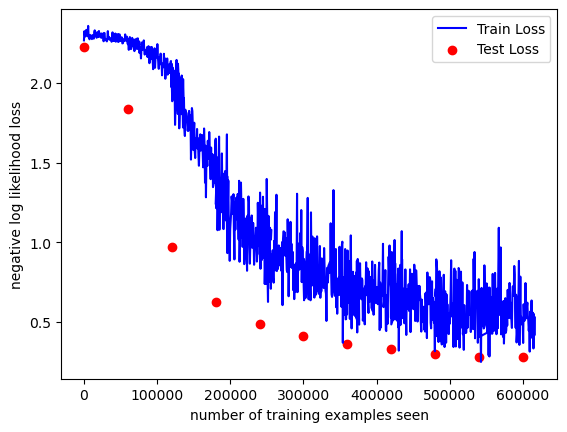

In [12]:
fig = plt.figure()
plt.plot(train_count, train_loss, color='blue')
plt.scatter(test_count, test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

/var/folders/4l/lh2gck1908s5qb7_dklnzyfc0000gn/T/ipykernel_8360/3801493435.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


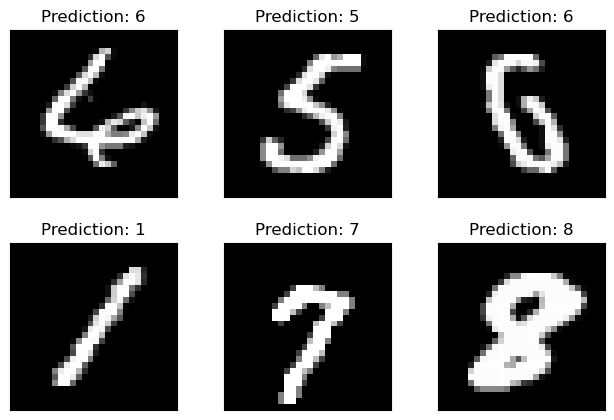

In [13]:
with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])